## MRI brain tumor classification

The dataset is composed of several MRI images showing 3 different types of brain tumors. This is packed into 2 datasets coded as tumor/non-tumor (1), and as no-tumor/specific condition datasets (2).

This notebook implements this the classification based on this paradigm. Used are multiple pretrained deep neural networks.

In [189]:
import gc
gc.collect()

75131

RGB


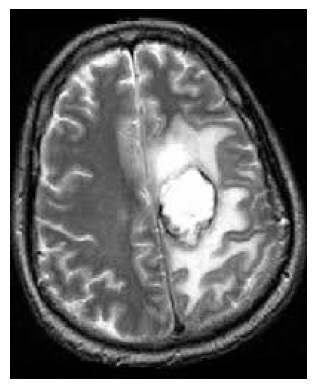

In [63]:
import os
import random
from PIL import Image

import matplotlib.pyplot as plt

# Set the directory path
directory = "../Data/brain_tumor_4variants/Testing/glioma_tumor"

# Get a list of all .jpg files in the directory
file_list = [file for file in os.listdir(directory) if file.endswith(".jpg")]

# Select a random image from the list
random_image = random.choice(file_list)

# Load and display the image
image_path = os.path.join(directory, random_image)
image = Image.open(image_path)
plt.imshow(image)
# print(image.mode)
plt.axis("off")
plt.show()

In [ ]:
import pandas as pd

# Set the directory paths
directories = ["../Data/brain_tumor_4variants/Training", "../Data/brain_tumor_4variants/Testing",
               "../Data/brain_tumor_4variants2/Training", "../Data/brain_tumor_4variants2/Testing"]

# Initialize empty lists to store the data
data_1 = []
data_2 = []

# Define the label mappings for the second dataset
label_mapping = {
    "no_tumor": 0,
    "notumor": 0,
    "glioma_tumor": 1,
    "glioma": 1,
    "meningioma_tumor": 2,
    "meningioma": 2,
    "pituitary_tumor": 3,
    "pituitary": 3
}

# Iterate through the directories
for directory in directories:
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            # Get a list of all .jpg files in the subdirectory
            file_list = [file for file in os.listdir(
                subdir_path) if file.endswith(".jpg")]

            # Append the data to data_1
            data_1.extend([(os.path.join(subdir_path, file), 0 if subdir in [
                          "no_tumor", "notumor"] else 1) for file in file_list])

            # Append the data to data_2
            data_2.extend([(os.path.join(subdir_path, file),
                          label_mapping[subdir]) for file in file_list])

# Create the datasets as pandas DataFrames
dataset_1 = pd.DataFrame(
    data_1, columns=["Image_Path", "Dependent_Variable_01"])
dataset_2 = pd.DataFrame(
    data_2, columns=["Image_Path", "Dependent_Variable_0123"])


In [70]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset

# Define the custom dataset class


class BrainTumorDataset(Dataset):
    def __init__(self, data_frame, transform=None):
        """
        Args:
            data_frame (pd.DataFrame): DataFrame with image paths and labels.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_frame = data_frame
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the item to fetch.
        
        Returns:
            tuple: (image, label) where image is the transformed image and label is the corresponding label.
        """
        img_path = self.data_frame.iloc[idx, 0]
        image = Image.open(img_path).convert("RGB")  # Convert to RGB
        label = self.data_frame.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label


# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    # Normalize with ImageNet mean and std
    transforms.Normalize(
        mean=[-1.3006, -1.2001, -0.9724], std=[0.8727, 0.8922, 0.8884])
])

# Create the datasets using the DataFrames created earlier
btd1 = BrainTumorDataset(data_frame=dataset_1, transform=transform)
btd2 = BrainTumorDataset(data_frame=dataset_2, transform=transform)

### Specify model

Beware that the final fully connected layer has either 2 or 4 neurons depending on which dataset is used. Using 2 neurons corresponds to tumor/no tumor diagnoses, while 4 differentiate between the different conditions of brain tumors.

In [71]:
import json
import torch.nn as nn
import safetensors.torch
from torchvision import models

# Step 1: Load the configuration
with open('../Models/resnet18/config.json', 'r') as f:
    config = json.load(f)

# Step 2: Load the weights
weights = safetensors.torch.load_file('../Models/resnet18/model.safetensors')

# Step 3: Initialize the model
model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, 4)

# Step 4: Load the weights into the model
model.load_state_dict(weights, strict=False)

# Verify the model
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Training pipeline

mps
Model is compatible with the input size.
Model output layer is compatible with the number of labels in the dataset.
Epoch 1/10, Training Loss: 0.827637463199849
Epoch 1/10, Accuracy: 44.34782608695652%
Epoch 2/10, Training Loss: 0.5795984311979644
Epoch 2/10, Accuracy: 68.38874680306905%
Epoch 3/10, Training Loss: 0.4677899427559911
Epoch 3/10, Accuracy: 39.130434782608695%
Epoch 4/10, Training Loss: 0.3641813327767411
Epoch 4/10, Accuracy: 72.89002557544757%
Epoch 5/10, Training Loss: 0.24995285016389526
Epoch 5/10, Accuracy: 91.09974424552429%
Epoch 6/10, Training Loss: 0.17716035786636022
Epoch 6/10, Accuracy: 85.52429667519182%
Epoch 7/10, Training Loss: 0.1398033355343707
Epoch 7/10, Accuracy: 92.89002557544757%
Epoch 8/10, Training Loss: 0.11497903836853042
Epoch 8/10, Accuracy: 30.895140664961637%
Epoch 9/10, Training Loss: 0.10138388246734988
Epoch 9/10, Accuracy: 68.23529411764706%
Epoch 10/10, Training Loss: 0.07164575278150792
Epoch 10/10, Accuracy: 49.667519181585675%


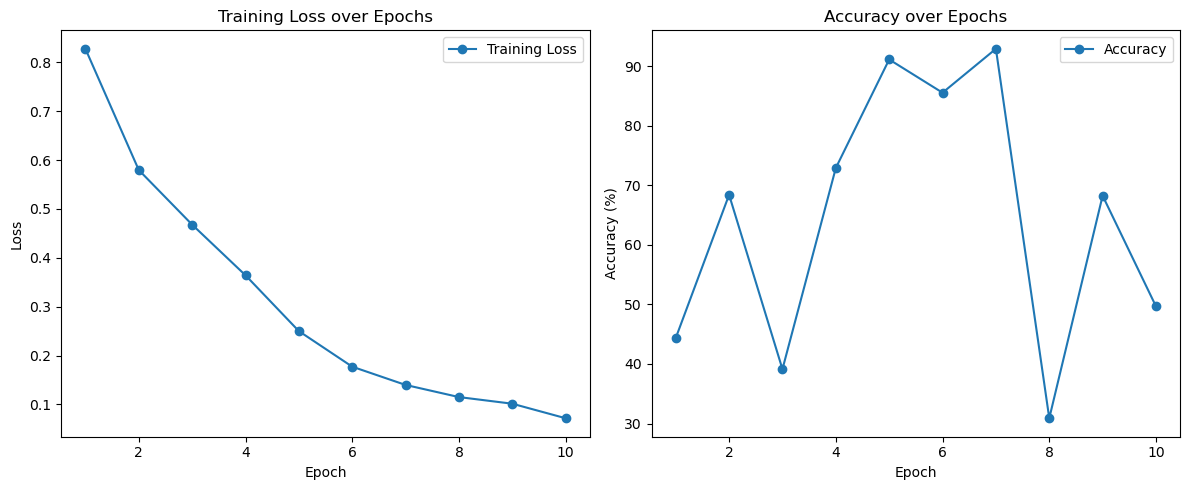

In [35]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

# Check if MPS is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

# Define the loss function and optimizer and learning rate
learning_rate = 0.002
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.7)

# Define dataset and dataloader
dataset = btd2

# Calculate sizes for training, validation, and testing sets
val_size = int(0.05 * len(dataset))
train_size = int(0.8 * (len(dataset) - val_size))
test_size = len(dataset) - train_size - val_size

# Split the dataset into training, validation, and testing sets
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32,
                          shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32,
                        shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32,
                         shuffle=True, num_workers=0)

# Assertion to check input dimensions

def check_input_compatibility(model, input_size=(3, 224, 224)):
    dummy_input = torch.randn(1, *input_size).to(device)
    try:
        model.to(device)
        model(dummy_input)
        print("Model is compatible with the input size.")
    except Exception as e:
        print(f"Model is not compatible with the input size: {e}")
        return False
    return True


def check_output_compatibility(model, train_dataset):
    try:
        # Move model to the appropriate device
        model.to(device)

        # Identify the number of different labels in the training dataset
        labels = [train_dataset[i][1] for i in range(len(train_dataset))]
        output_categories = len(set(labels))

        # Check if the model's output layer has the same number of neurons as the number of labels
        if model.fc.out_features != output_categories:
            print(
                f"Model has {model.fc.out_features} neurons at the final layer, but {output_categories} labels in the dataset.")
            return False
        print("Model output layer is compatible with the number of labels in the dataset.")
    except Exception as e:
        print(f"Model has fewer/more neurons at final layer: {e}")
        return False
    return True


assert check_input_compatibility(model) == True
assert check_output_compatibility(model, dataset) == True

# Training and testing loop
num_epochs = 10
train_losses = []
accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}")

    # Testing phase
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    accuracies.append(accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Accuracy: {accuracy}%")

# Plotting the performance
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses,
         marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracies, marker='o', label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

mps
Model is compatible with the input size.
Model output layer is compatible with the number of labels in the dataset.
Epoch 1/25, Training Loss: 0.04271263811146704
Epoch 1/25, Accuracy: 98.44458846403111%
New best model saved at epoch 1
Epoch 2/25, Training Loss: 0.03777319578717962
Epoch 2/25, Accuracy: 98.76863253402463%
New best model saved at epoch 2
Epoch 3/25, Training Loss: 0.029983132841951417
Epoch 3/25, Accuracy: 98.63901490602721%
Epoch 4/25, Training Loss: 0.02711733612441316
Epoch 4/25, Accuracy: 99.22229423201556%
New best model saved at epoch 4
Epoch 5/25, Training Loss: 0.02775654710144963
Epoch 5/25, Accuracy: 98.50939727802981%
Epoch 6/25, Training Loss: 0.029190514431755264
Epoch 6/25, Accuracy: 99.35191186001296%
New best model saved at epoch 6
Epoch 7/25, Training Loss: 0.020675669537492312
Epoch 7/25, Accuracy: 98.96305897602073%
Epoch 8/25, Training Loss: 0.012648330274177857
Epoch 8/25, Accuracy: 92.48217757615036%
Epoch 9/25, Training Loss: 0.019591065178371

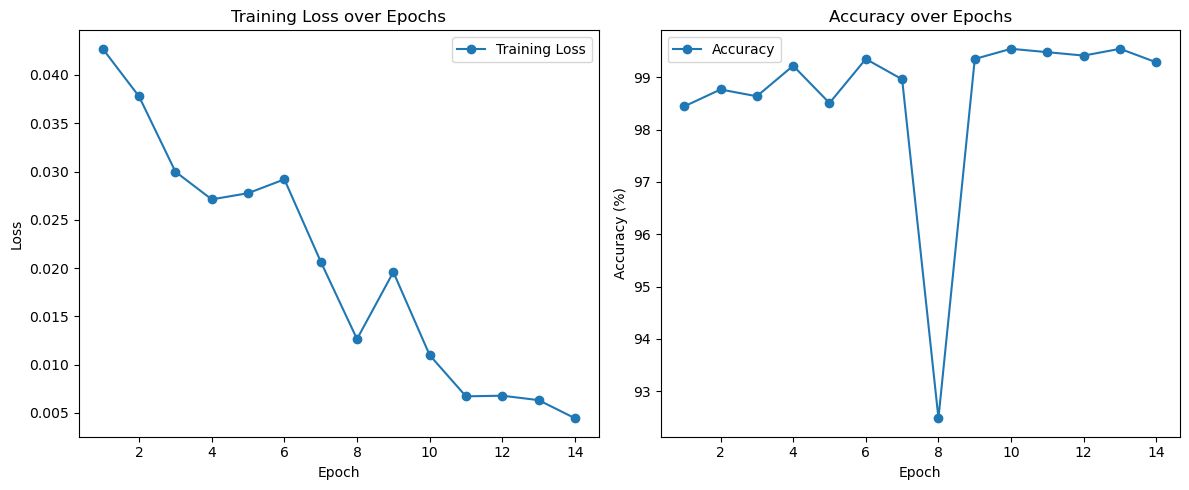

In [159]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt

# Check if MPS is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

# Define the loss function and optimizer and learning rate
learning_rate = 0.005
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.7)

# Initialize the learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.05, patience=1)

# Define dataset and dataloader
dataset = btd2

# Calculate sizes for training, validation, and testing sets
val_size = int(0.15 * len(dataset))
train_size = int(0.75 * (len(dataset) - val_size))
test_size = len(dataset) - train_size - val_size

# Split the dataset into training, validation, and testing sets
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32,
                          shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32,
                        shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32,
                         shuffle=True, num_workers=0)

# Assertion to check input dimensions


def check_input_compatibility(model, input_size=(3, 224, 224)):
    dummy_input = torch.randn(1, *input_size).to(device)
    try:
        model.to(device)
        model(dummy_input)
        print("Model is compatible with the input size.")
    except Exception as e:
        print(f"Model is not compatible with the input size: {e}")
        return False
    return True


def check_output_compatibility(model, train_dataset):
    try:
        # Move model to the appropriate device
        model.to(device)

        # Identify the number of different labels in the training dataset
        labels = [train_dataset[i][1] for i in range(len(train_dataset))]
        output_categories = len(set(labels))

        # Check if the model's output layer has the same number of neurons as the number of labels
        if model.fc.out_features != output_categories:
            print(
                f"Model has {model.fc.out_features} neurons at the final layer, but {output_categories} labels in the dataset.")
            return False
        print("Model output layer is compatible with the number of labels in the dataset.")
    except Exception as e:
        print(f"Model has fewer/more neurons at final layer: {e}")
        return False
    return True


assert check_input_compatibility(model) == True
assert check_output_compatibility(model, dataset) == True


# Training and testing loop
num_epochs = 25
train_losses = []
accuracies = []
best_accuracy = 0
epochs_without_improvement = 0
early_stopping_patience = 4

# New: Initialize variables for model checkpointing
best_model_state = None
best_epoch = 0

for epoch in range(num_epochs):
    # Apply data augmentation to the training dataset at the beginning of each epoch
    if epoch > 0:
        # Define data augmentation transformations
        augmentation_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),  # Rotate by 10 degrees
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

        train_dataset.dataset.transform = augmentation_transforms

    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}")

    # Testing phase
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    accuracies.append(accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Accuracy: {accuracy}%")

    # Step the scheduler
    scheduler.step(accuracy)
    
    # Model checkpointing
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_state = model.state_dict()
        best_epoch = epoch
        epochs_without_improvement = 0
        print(f"New best model saved at epoch {epoch+1}")
    else:
        epochs_without_improvement += 1

    # Early stopping condition
    if epochs_without_improvement >= early_stopping_patience:
        print(
            f"Early stopping triggered. Best model was from epoch {best_epoch+1}")
        break

# Load the best model after training
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Loaded best model from epoch {best_epoch+1}")

# Plotting the performance
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses,
         marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(accuracies) + 1),
         accuracies, marker='o', label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

### Validation

Run next cell for statistical results of classification on unseen data.

Run the following cell to obtain single image classification results.

In [161]:
import torch.nn.functional as F


def test(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100.0 * correct / total

    print(
        f'Validation Loss: {test_loss:.4f}, Validation Accuracy: {accuracy:.2f}%')


# Assuming you have already defined your model, criterion, and device
# Example usage:
test(model, test_loader, criterion, device)

Validation Loss: 0.0171, Validation Accuracy: 99.36%


In [162]:
import numpy as np

def eval_perform(model, dataset):
    # Set the model to evaluation mode
    model.eval()

    # Pick a random image from the dataset
    idx = random.randint(0, len(dataset) - 1)
    image, label = dataset[idx]

    # Prepare the image for the model
    # Add batch dimension and move to device
    image = image.unsqueeze(0).to(device)

    # Run the model on the image
    with torch.no_grad():
        logits = model(image)

    # Calculate probabilities
    probabilities = torch.softmax(logits, dim=1)

    # Display the image
    image_np = image.squeeze(0).cpu().numpy().transpose((1, 2, 0))
    
    plt.imshow(image_np)
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

    return logits, probabilities, label

# Example usage:
# logits, probabilities = eval_perform(model, test_dataset, device)
# print("Logits:", logits)
# print("Probabilities:", probabilities)

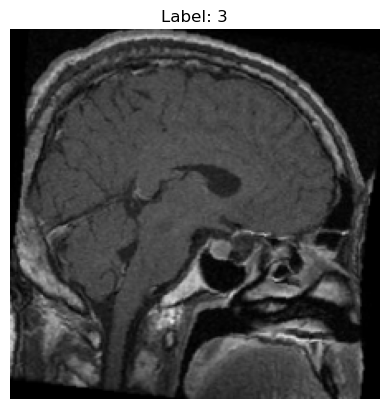

Probabilities: tensor([[2.5899e-09, 1.6673e-08, 2.2817e-07, 1.0000e+00]], device='mps:0')
Prediction: 3
Label: 3


In [186]:
logits, probabilities, label = eval_perform(model, test_dataset)
print("Probabilities:", probabilities)
_, prediction = torch.max(probabilities.data, 1)
print("Prediction:", int(prediction))
print("Label:", label)

In [188]:
# Save model 
torch.save(model.state_dict(), '../Models/resnet_mri_010824.pth')